In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

## Discrete data + probability


In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})

rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

rm_df = rm_df.merge(rm_df2)

rm_df[rm_df.rm_proba < .01]


,request_method,rm_count,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/HTTP/1.1,3,0.000215
11,GET /api/v1/sales/ HTTP/1.1,3,0.000215
12,GET /api/v1/store HTTP/1.1,3,0.000215


22
                                  request_method  rm_count  rm_proba
12                    GET /api/v1/store HTTP/1.1         3  0.000215
13               GET /api/v1/itemsitems HTTP/1.1         3  0.000215
14                     GET /api/v1items HTTP/1.1         2  0.000143
15                  GET /api/V1/HiZach! HTTP/1.1         1  0.000072
16                    GET /api/v1/items/HTTP/1.1         1  0.000072
17             GET /api/v1/items&page=0 HTTP/1.1         1  0.000072
18              GET /api/v1/helloclass! HTTP/1.1         1  0.000072
19  GET /api/v1//api/v1/items/next_page HTTP/1.1         1  0.000072
20        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1  0.000072
21                          GET /api/v1 HTTP/1.1         1  0.000072


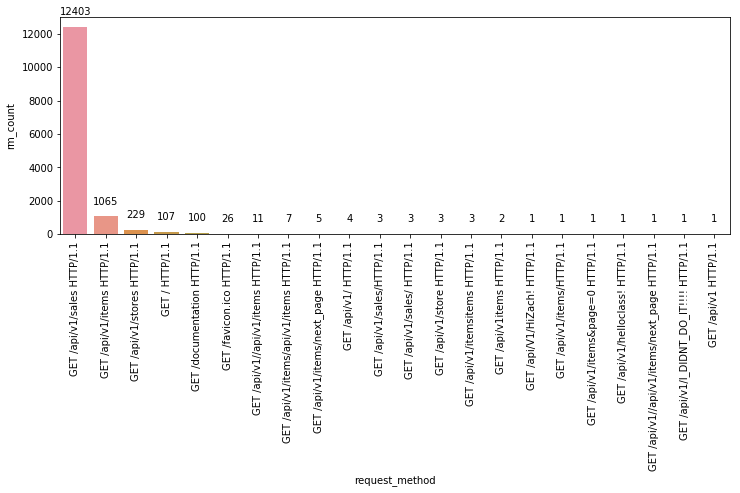

In [7]:
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 15), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')


In [8]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent']]


In [9]:
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})


In [10]:
rm_df

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156
5,GET /favicon.ico HTTP/1.1,0.001861
6,GET /api/v1//api/v1/items HTTP/1.1,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,0.000358
9,GET /api/v1/ HTTP/1.1,0.000286


In [11]:
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.rm_proba.value_counts()


0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: rm_proba, dtype: int64

In [12]:
rm_probs = train.groupby('request_method').size().div(len(df))

request_given_ip = pd.DataFrame(train.groupby(['request_method', 'ip']).\
                               size().div(len(train)).\
                               div(rm_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_request_given_ip'})
                              )

In [13]:
rm_status_count = pd.DataFrame(train.groupby(['request_method', 'ip'])['status'].\
                                count().reset_index())

rm_status = request_given_ip.merge(rm_status_count)


In [14]:
df = df.reset_index().merge(rm_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')


In [15]:
df.head()

,ip_x,request_method,status,size,destination,request_agent,rm_proba,ip_y,proba_request_given_ip
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.887577,0,0.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.076213,0,0.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.887577,0,0.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.887577,0,0.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.887577,0,0.0


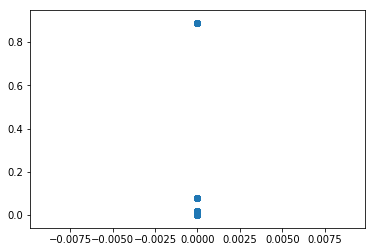

In [16]:
plt.scatter(df.proba_request_given_ip, df.rm_proba)


## Time series + EMA


In [17]:
df = pd.read_csv('anonymized-curriculum-access.txt', header=None, sep=' ')

In [18]:
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [19]:
df['datetime'] = df[0] + ' ' + df[1]

In [20]:
df.drop(columns=[0,1], inplace=True)

In [21]:
df.index = pd.to_datetime(df.datetime)
df.drop(columns='datetime', inplace=True)

In [22]:
df.rename(columns={2: 'address', 3: 'id', 4: 'cohort_id', 5:'ip_address'}, inplace=True)

In [23]:
df.fillna(0, inplace=True)

In [24]:
df.head()

,address,id,cohort_id,ip_address
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


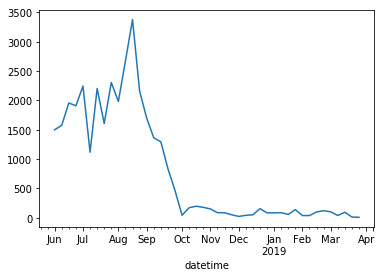

In [25]:
df24 = df[df['cohort_id']==24]

df24['id'].resample('W').agg('count').plot()

In [26]:
df.dtypes

address        object
id              int64
cohort_id     float64
ip_address     object
dtype: object

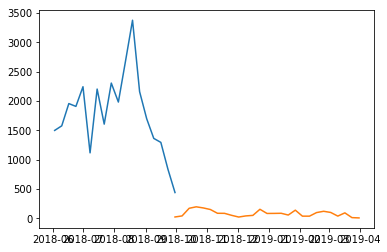

In [27]:
train = df24[:'2018-09-29']['id'].resample('W').agg('count')
test = df24['2018-09-30':]['id'].resample('W').agg('count')
plt.plot(train)
plt.plot(test)


In [28]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=4).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=8).mean()

Text(0, 0.5, 'id total')

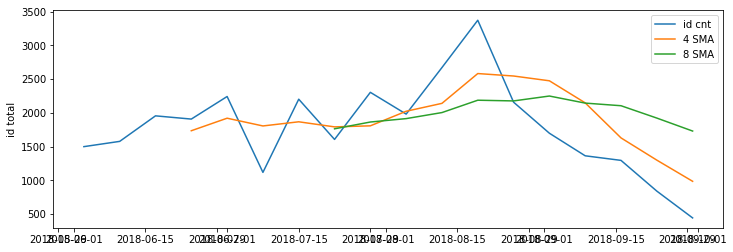

In [29]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='id cnt')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '4 SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '8 SMA')

ax.legend(loc='best')
ax.set_ylabel('id total')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

In [30]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=12, adjust=False).mean()
ema_long[0:3]

datetime
2018-06-03    1498.000000
2018-06-10    1510.000000
2018-06-17    1578.461538
Freq: W-SUN, Name: id, dtype: float64

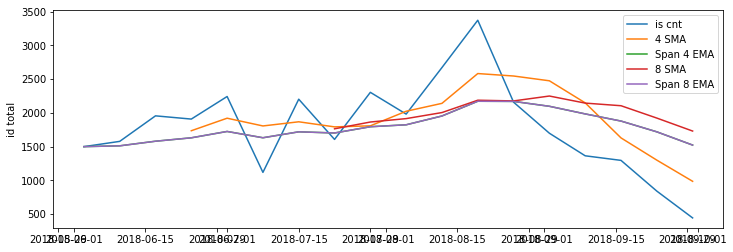

In [31]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='is cnt')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '4 SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 4 EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '8 SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 8 EMA')

ax.legend(loc='best')
ax.set_ylabel('id total')

yhat = pd.DataFrame(dict(actual=test))

In [44]:
span = 7
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

In [45]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [46]:
yhat[yhat.pct_b > 1]


,actual,moving_avg_forecast,error,pct_b
datetime,,,,


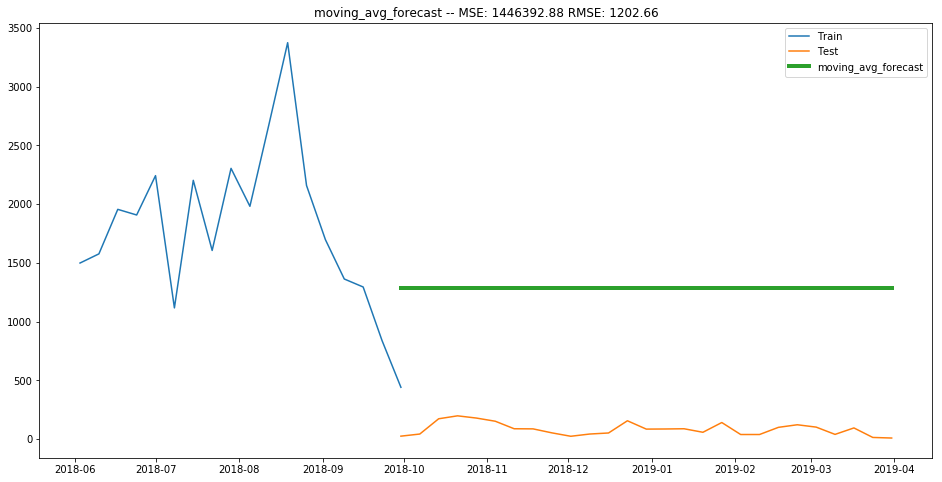

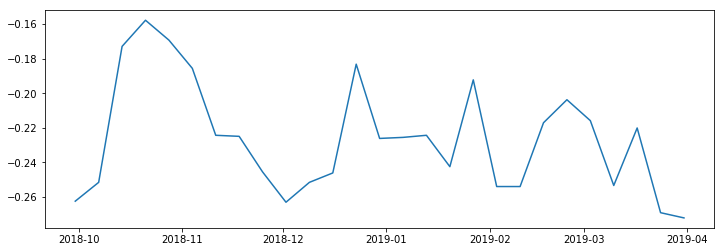

In [47]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)


In [68]:
df[df['cohort_id']==22]

,address,id,cohort_id,ip_address
datetime,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:58:26,javascript-i/functions,4,22.0,97.105.19.61
2018-01-26 09:59:22,mkdocs/search_index.json,5,22.0,97.105.19.61
2018-01-26 10:00:02,javascript-i/introduction/working-with-data-ty...,6,22.0,97.105.19.61
2018-01-26 10:00:37,/,6,22.0,97.105.19.61
